In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

AU_TO_EV = 27.2113961317875

# Коэффициент связанного состояния

Асимптотика связанного состояния: $\psi_{\text{bound}} \approx C x^{z/\kappa}\exp(-\kappa x)$

In [13]:
# асимптотика связанного состояния
def psi_bound_asymp(x, C, z, kappa):
    return C*x**(z/kappa)*np.exp(-kappa * x)

## Ar18

In [45]:
z=18; Ip=162; E=100; a=0.078
kappa = np.sqrt(2*Ip)

curve_fit =  (array([-16.32907358]), array([[0.00058772]]))
C_fit =  16.32907358173318


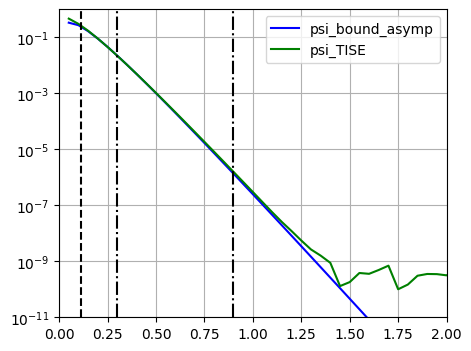

In [11]:
# применимость асимптотики
x_asymp = z/Ip

# начальное состояние из TISE1D
x = np.load("/home/denis/RustSSFM/RSSFM2D/src/out/dim1/x0.npy")
psi_initial = np.load("/home/denis/RustSSFM/RSSFM2D/src/out/dim1/psi_initial.npy")
mask = (x > 0.01)
x = x[mask]
psi_initial = psi_initial[mask]

# фитируем
x_for_fit = [0.3, 0.9]
mask = (x > x_for_fit[0]) & (x < x_for_fit[1])
x_fit = x[mask]
psi_initial_fit = psi_initial[mask]
curve_fit = sp.optimize.curve_fit(lambda x, C: psi_bound_asymp(x, C, z, kappa), x_fit, psi_initial_fit)
C_fit = np.abs(curve_fit[0][0])
print("curve_fit = ", curve_fit)
print("C_fit = ", C_fit)

# график
fig, ax = plt.subplots(1, 1, figsize = (5, 4))
ax.plot(x, np.abs(psi_bound_asymp(x, C_fit, z, kappa)), color="blue", label="psi_bound_asymp")
ax.plot(x, np.abs(psi_initial), color="green", label="psi_TISE")
ax.axvline(x_asymp, color='black', linestyle='--')
ax.axvline(x_for_fit[0], color='black', linestyle='-.')
ax.axvline(x_for_fit[1], color='black', linestyle='-.')
# ax.set(xlim=[0, 2], ylim=[0, 0.1])
ax.set(xlim=[0, 2], ylim=[1e-11, 1])
ax.set_yscale("log")
ax.grid(); ax.legend();

Фитировать будем на промежутке $x=[0.3, 0.9]$

# Сшивка асимптотики связанного состояния и ВКБ

Обозначения:

$z$ - заряд остова

$\kappa=\sqrt{2I_P}$

Импульс: 
$p=\sqrt{\dfrac{2z}{\sqrt{x^2+a^2}} + 2Ex - \kappa^2}$

In [96]:
# зависимость импульса от координаты
def p(x, z, kappa, a, E):
    return np.sqrt(2*z/np.sqrt(x**2+a**2) + 2*E*x - kappa**2 + 0j)

Уравнение на точки поворота: 
$\kappa^2-\dfrac{2z}{\sqrt{x^2 + a^2}} - 2Ex = 0$

Первое приближение: 
$~~~x_{in}=\dfrac{z}{I_p} = \dfrac{2z}{\kappa^2}$;
$~~~x_{out}=\dfrac{Ip}{E} = \dfrac{\kappa^2}{2E}$

In [98]:
# точки поворота
def get_x(z, kappa, a, E):
    x_in = 2*z/kappa**2
    x_out = kappa**2 / (2*E)
    x_in = sp.optimize.root_scalar(lambda x: 2*z/np.sqrt(x**2+a**2) + 2*E*x - kappa**2, x0 = x_in)["root"]
    x_out = sp.optimize.root_scalar(lambda x: 2*z/np.sqrt(x**2+a**2) + 2*E*x - kappa**2, x0 = x_out)["root"]
    return x_in, x_out

Квазиклассическая функция под барьером: $\psi_{sc} = \dfrac{A}{\sqrt{|p|}}\exp\left( -\int\limits_{x_0}^{x} |p| dx \right)$

In [105]:
# квазиклассическая в.ф. под барьером
def psi_sc_under(x, A, z, kappa, a, E):
    x_in, x_out = get_x(z, kappa, a, E)
    integral = sp.integrate.quad(lambda x: np.abs(p(x, z, kappa, a, E)), x_in, x)[0]
    return A/np.sqrt(np.abs(p(x, z, kappa, a, E))) * np.exp(-integral)
psi_sc_under = np.vectorize(psi_sc_under)

Применимость квазиклассики около левой точки поворота: $\left|\dfrac{d}{dx}\dfrac{1}{p}\right|\ll 1$

$$
\left| \dfrac{zx}{(x^2+a^2)^{3/2}\left( \dfrac{2 z}{\sqrt{x^2+a^2}} - \kappa^2\right)^{3/2}} \right| \ll 1
$$

In [106]:
def vkb_applty(x, z, kappa, a):
    return z*x/( 
        (x**2+a**2)**(3/2)*(np.abs(2*z/np.sqrt(x**2+a**2) - kappa**2))**(3/2) 
    )

## Рассмотрим Ar18

In [107]:
x_in, x_out = get_x(z, kappa, a, E)
print(f"z/Ip = {z/Ip}")
print(f"z/kappa = {z/kappa}")
print(f"aB = {z/kappa**2}")
print(f"x_in = {x_in}")
print(f"x_out = {x_out}")

z/Ip = 0.1111111111111111
z/kappa = 1.0
aB = 0.05555555555555555
x_in = 0.08882948296869554
x_out = 1.5001714557455288


vkb_applty = 0.47730504127391726
vkb_fit = (array([0.71607008]), array([[1.39399315e-05]]))
A_fit = 0.7160700800742072


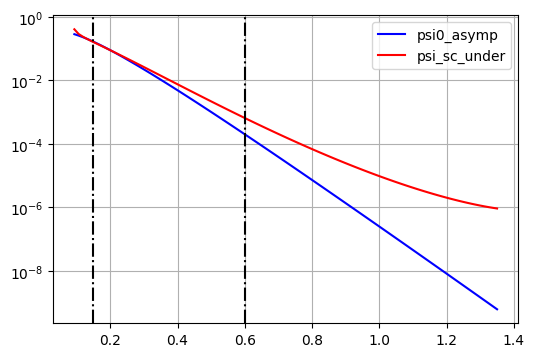

In [114]:
x = np.linspace(1.05*x_in, 0.9*x_out, 100)

x_for_fit = [0.15, 0.6]
print(f"vkb_applty = {vkb_applty(x_for_fit[0], z, kappa, a)}")
x_fit = np.linspace(x_for_fit[0], x_for_fit[1], 100)
vkb_fit = sp.optimize.curve_fit(lambda x, A: psi_sc_under(x, A, z, kappa, a, E), x_fit, psi_bound_asymp(x_fit, C_fit, z, kappa))
A_fit = np.abs(vkb_fit[0][0])
print(f"vkb_fit = {vkb_fit}")
print(f"A_fit = {A_fit}")


fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(x, psi_bound_asymp(x, C_fit, z, kappa), color = "blue", label="psi0_asymp")
ax.plot(x, psi_sc_under(x, A_fit, z, kappa, a, E), color = "red", label="psi_sc_under")
ax.axvline(x_for_fit[0], color='black', linestyle='-.')
ax.axvline(x_for_fit[1], color='black', linestyle='-.')
# ax.set(xlim=[0.1, 0.3], ylim=[1e-3, 1])
ax.set(yscale = 'log')
ax.grid(); ax.legend();

## Сшивка квазиклассики со связанным состоянием вблизи нуля

0.23918025063683823


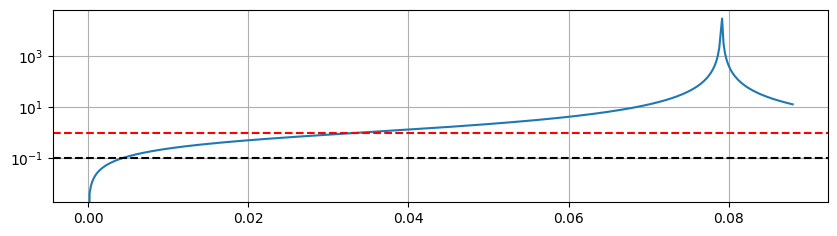

In [136]:
# область применимости квазиклассики
print(vkb_applty(0.01, z, kappa, a))
fig, ax = plt.subplots(1, 1, figsize=(10, 2.5))
x = np.linspace(0, 0.088, 500)
ax.plot(x, vkb_applty(x, z, kappa, a))
ax.axhline(0.1, color='black', linestyle="--")
ax.axhline(1, color='red', linestyle="--")
ax.set_yscale("log")
ax.grid();

Импульс вблизи нуля: $p = \sqrt{\dfrac{2z}{\sqrt{x^2+a^2}} - \kappa^2}$,
где $a$ - сглаживающий параметр

In [127]:
def p_bound(x, z, kappa, a):
    return np.sqrt(
        np.abs(2*z/np.sqrt(x**2+a**2) - kappa**2)
    )

Квазиклассическая волновая функция слева от барьера:
$\psi_{sc0} = \dfrac{2A}{\sqrt{p}}\cos\left( \left|\int\limits_{x_{in}}^x pdx \right| - \dfrac{\pi}{4} \right)$

In [154]:
def psi_sc_0(x, A, z, kappa, a, E):
    x_in, x_out = get_x(z, kappa, a, E)
    integral = sp.integrate.quad(lambda x: p_bound(x, z, kappa, a), 0, x)[0]
    return 2*A/np.sqrt(p_bound(x, z, kappa, a)) * np.exp(np.abs(integral))
psi_sc_0 = np.vectorize(psi_sc_0)

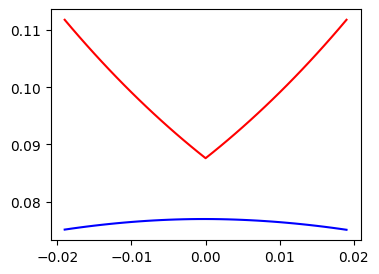

In [156]:
# начальное состояние из TISE1D
x = np.load("/home/denis/RustSSFM/RSSFM2D/src/out/dim1/x0_around_0.npy")
psi_initial = np.load("/home/denis/RustSSFM/RSSFM2D/src/out/dim1/psi_initial_around_0.npy")
mask = (x > -0.02) & (x < 0.02)
x = x[mask]
psi_initial = psi_initial[mask]
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(x, np.abs(psi_sc_0(x, 0.15, z, kappa, a, E)), color="red");
ax.plot(x, np.abs(psi_initial), color="blue");
# ax.set_yscale("log")